# 13장

In [2]:
import tensorflow as tf

# TensorFlow의 로깅 수준을 설정
tf.get_logger().setLevel('ERROR')

In [3]:
import tensorflow as tf
import numpy as np

X = tf.range(10)
dataset = tf.data.Dataset.from_tensor_slices(X) # 각 원소를 아이템으로 변환
print(dataset)
for item in dataset:
    print(item)
print('='*10)

dataset2 = dataset.repeat(3).batch(7)   # 3번 반복, 배치 크기 7
for item in dataset2:
    print(item)
print('='*10)

dataset2 = dataset.map(lambda x: x*2)   # 데이터에 함수 적용
dataset2 = dataset2.repeat(3).batch(7, drop_remainder=True) # 배치 크기보다 작은 데이터 버림
for item in dataset2:
    print(item)
print('='*10)

dataset2 = dataset2.apply(tf.data.experimental.unbatch())   # 배치 해제(배치 크기 1)
for item in dataset2:
    print(item)
print('='*10)

dataset2 = dataset2.filter(lambda x: x < 10)    # 필터
for item in dataset2:
    print(item)
print('='*10)

for item in dataset2.take(3):   # 인자 값의 길이만큼만 반환.(One-based indexing)
    print(item)

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)
tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int32)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)

In [4]:
dataset = tf.data.Dataset.range(10).repeat(3)
dataset = dataset.shuffle(buffer_size=5, seed=42).batch(7)
# buffer_size만큼 순서대로 추출 후 임의값 1개 추출, 다음 값으로 buffer 채움. 반복.
for item in dataset:
    print(item)

tf.Tensor([0 2 3 6 7 9 4], shape=(7,), dtype=int64)
tf.Tensor([5 0 1 1 8 6 5], shape=(7,), dtype=int64)
tf.Tensor([4 8 7 1 2 3 0], shape=(7,), dtype=int64)
tf.Tensor([5 4 2 7 8 9 9], shape=(7,), dtype=int64)
tf.Tensor([3 6], shape=(2,), dtype=int64)


In [5]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

In [6]:
import csv, os
from glob import glob

os.makedirs('dataset_hosing', exist_ok=True)
header_cols = housing.feature_names + ["MedianHouseValue"]

def make_data_files(data_using_type: str, X: np.array, y: np.array, split_nums: int=10) -> list:
    for idx, data in enumerate(np.array_split(np.column_stack((X, y)), split_nums)):
        with open(f'dataset_hosing/{data_using_type}_{idx:0>2}.csv', 'w') as f:
            writer = csv.writer(f)
            writer.writerows(np.row_stack((header_cols, data)))
    
    return glob(f'dataset_hosing/{data_using_type}*.csv')

train_filepaths = make_data_files("train", X_train, y_train, 20)
valid_filepaths = make_data_files("valid", X_valid, y_valid)
test_filepaths = make_data_files("test", X_test, y_test)

In [7]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)
# tf.data.Dataset.list_files: 파일들의 경로 리스트로 dataset 생성

n_readers = 5
dataset = filepath_dataset.interleave(  # tf.data.Dataset.interleave: dataset에 함수를 적용하여 병렬로 데이터 읽음.
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1), # 첫 행 스킵(컬럼명)
    cycle_length=n_readers  # 병렬로 읽을 dataset 수
)
# tf.data.TextLineDataset: 텍스트 파일 데이터를 한 줄씩 읽음.

for line in dataset.take(5):
    print(line.numpy())

b'4.2083,44.0,5.323204419889502,0.9171270718232044,846.0,2.3370165745856353,37.47,-122.2,2.782'
b'4.1812,52.0,5.701388888888889,0.9965277777777778,692.0,2.4027777777777777,33.73,-118.31,3.215'
b'3.6875,44.0,4.524475524475524,0.993006993006993,457.0,3.195804195804196,34.04,-118.15,1.625'
b'3.3456,37.0,4.514084507042254,0.9084507042253521,458.0,3.2253521126760565,36.67,-121.7,2.526'
b'3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442'


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_mean = scaler.mean_
X_std = scaler.scale_
n_inputs = 8

@tf.function
def preprocess(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    # defs=기본값 지정: 각 input에 0. 기본값 + y는 tf.float32 타입의 빈 배열(실수지만 기본값 없음: 값 누락 시 오류 발생)
    fields = tf.io.decode_csv(line, record_defaults=defs)
    # csv 형식의 문자열을 단일 값인 0차원 스칼라 텐서로 변환
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])

    return (x - X_mean) / X_std, y

print(preprocess(line.numpy()))

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([-0.19397889, -1.0778131 , -0.9433855 ,  0.01485314,  0.02073332,
       -0.57291615,  0.92926127, -1.4221538 ], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.442], dtype=float32)>)


In [9]:
def csv_reader_dataset(filepaths, repeat=1, n_readers=5,
                       n_read_threads=None, shuffle_buffer_size=10000,
                       n_parse_threads=5, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    
    return dataset.batch(batch_size).prefetch(1)
    # 항상 1개 배치 미리 준비

In [10]:
train_set = csv_reader_dataset(train_filepaths, repeat=None)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

In [11]:
from tensorflow import keras

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
])
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

batch_size = 128
model.fit(train_set, steps_per_epoch=len(X_train) // batch_size, epochs=10,
          validation_data=valid_set)
model.evaluate(test_set, steps=len(X_test) // batch_size)

Epoch 1/10
90/90 [==============================] - 1s 3ms/step - loss: 3.7020 - val_loss: 9.8191
Epoch 2/10
90/90 [==============================] - 0s 3ms/step - loss: 1.9768 - val_loss: 10.8591
Epoch 3/10
90/90 [==============================] - 0s 3ms/step - loss: 1.1748 - val_loss: 11.9542
Epoch 4/10
90/90 [==============================] - 0s 2ms/step - loss: 0.9293 - val_loss: 11.8668
Epoch 5/10
90/90 [==============================] - 0s 2ms/step - loss: 1.1724 - val_loss: 1.1358
Epoch 6/10
90/90 [==============================] - 0s 2ms/step - loss: 0.7592 - val_loss: 1.0355
Epoch 7/10
90/90 [==============================] - 0s 2ms/step - loss: 0.7334 - val_loss: 0.7585
Epoch 8/10
90/90 [==============================] - 0s 2ms/step - loss: 0.7351 - val_loss: 0.7324
Epoch 9/10
90/90 [==============================] - 0s 2ms/step - loss: 0.7331 - val_loss: 0.7056
Epoch 10/10
40/40 [==============================] - 0s 798us/step - loss: 0.7474


0.7474496960639954

In [12]:
# `Dataset` 클래스에 있는 메서드의 간략한 설명입니다:
for m in dir(tf.data.Dataset):
    if not (m.startswith("_") or m.endswith("_")):
        func = getattr(tf.data.Dataset, m)
        if hasattr(func, "__doc__"):
            print("● {:21s}{}".format(m + "()", func.__doc__.split("\n")[0]))

● apply()              Applies a transformation function to this dataset.
● as_numpy_iterator()  Returns an iterator which converts all elements of the dataset to numpy.
● batch()              Combines consecutive elements of this dataset into batches.
● bucket_by_sequence_length()A transformation that buckets elements in a `Dataset` by length.
● cache()              Caches the elements in this dataset.
● cardinality()        Returns the cardinality of the dataset, if known.
● choose_from_datasets()Creates a dataset that deterministically chooses elements from `datasets`.
● concatenate()        Creates a `Dataset` by concatenating the given dataset with this dataset.
● counter()            Creates a `Dataset` that counts from `start` in steps of size `step`.
● element_spec()       The type specification of an element of this dataset.
● enumerate()          Enumerates the elements of this dataset.
● filter()             Filters this dataset according to `predicate`.
● flat_map()        

In [13]:

with tf.io.TFRecordWriter('my_data.tfrecord') as f:
    f.write(b'This is the first record')
    f.write(b'and this is the second record')
    # 현재는 바이트 문자열이 아닌 그냥 문자열로 입력해도 알아서 변환됨.

filepaths = ['my_data.tfrecord']
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'and this is the second record', shape=(), dtype=string)


In [14]:
options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("my_compressed.tfrecord", options) as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

dataset = tf.data.TFRecordDataset(["my_compressed.tfrecord"],
                                  compression_type="GZIP")
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


```java
syntax = "proto3";  // proto3 버전 사용
message Person {    // Person이란 message 정의
    string name = 1;// 자료형 필드명 = 필드식별자
    int32 id = 2;
    repeated string email = 3
};
```

```python
from person_pb2 import Person   # 생성된 클래스 임포트
person = Person(name="Al", id=123, email=["a@b.com"])   # Person 객체 생성
print(person)
person.name = "Alice"
person.email.append("c@d.com")
print(person.name, person.email[1])

s = person.SerializeToString()  # 바이트 문자열로 객체 직렬화
print(s)
person2 = Person()
print(person2.ParseFromString(s))
print(person == person2)
```

```java
syntax = "proto3";

message BytesList { repeated bytes value = 1; }
message FloatList { repeated float value = 1 [packed = true]; } // [packed = true]: 값을 압축된 형식으로 저장.
message Int64List { repeated int64 value = 1 [packed = true]; }
message Feature {
    oneof kind {    // "oneof":하나의 메시지에서 여러 필드 중 하나만 사용할 수 있음.
        BytesList bytes_list = 1;
        FloatList float_list = 2;
        Int64List int64_list = 3;
    }
};
message Features { map<string, Feature> feature = 1; };     // Features는 특성 이름과 값을 매핑한 딕셔너리를 가짐.

message Example { Features features = 1; }; // 하나의 Features 객체를 가짐.
```

In [15]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

person_example = Example(
    features = Features(
        feature = {
            "name": Feature(bytes_list = BytesList(value=[b"Alice"])),
            "id": Feature(int64_list = Int64List(value=[123])),
            "emails": Feature(bytes_list = BytesList(value=[b"a@b.com",
                                                            b"c@d.com"]))
        }
    )
)

with tf.io.TFRecordWriter("my_contacts.tfrecord") as f:
    f.write(person_example.SerializeToString())

In [16]:
feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "emails": tf.io.VarLenFeature(tf.string)
}

for serialized_example in tf.data.TFRecordDataset(["my_contacts.tfrecord"]):
    parsed_example = tf.io.parse_single_example(serialized_example, feature_description)
    # tf.io.parse_single_example: 하나씩 파싱, 딕셔너리로 반환
print(tf.sparse.to_dense(parsed_example["emails"], default_value=b""))
# tf.sparse.to_dense: 희소 텐서를 밀집 텐서로 변환
print(parsed_example["emails"].values)
display(parsed_example)

for serialized_example in tf.data.TFRecordDataset(["my_contacts.tfrecord"]).repeat(13).batch(10):
    parsed_example = tf.io.parse_example(serialized_example, feature_description)
    # tf.io.parse_example: 배치 단위 파싱, 딕셔너리로 반환
print(parsed_example["name"].numpy())   # SparseTensor가 아니라 .numpy() 사용
display(parsed_example) # 반복문에서 할당이기에 마지막 배치를 할당하여 호출

tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string)
tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string)


{'emails': SparseTensor(indices=tf.Tensor(
 [[0]
  [1]], shape=(2, 1), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string), dense_shape=tf.Tensor([2], shape=(1,), dtype=int64)),
 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}

[b'Alice' b'Alice' b'Alice']


{'emails': SparseTensor(indices=tf.Tensor(
 [[0 0]
  [0 1]
  [1 0]
  [1 1]
  [2 0]
  [2 1]], shape=(6, 2), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com' b'a@b.com' b'c@d.com' b'a@b.com' b'c@d.com'], shape=(6,), dtype=string), dense_shape=tf.Tensor([3 2], shape=(2,), dtype=int64)),
 'id': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([123, 123, 123], dtype=int64)>,
 'name': <tf.Tensor: shape=(3,), dtype=string, numpy=array([b'Alice', b'Alice', b'Alice'], dtype=object)>}

```java
message FeatureList { repeated Feature feature = 1; };
message FeatureList { map<string, FeatureList> feature_list = 1; };
message SequenceExample {
    Features context = 1;
    FeatureLists feature_lists = 2;
};
```

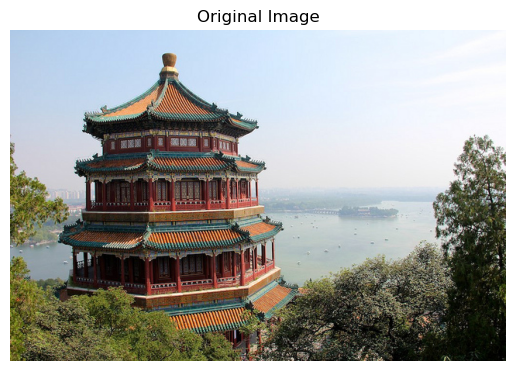

In [17]:
from sklearn.datasets import load_sample_images
import matplotlib.pyplot as plt

img = load_sample_images()["images"][0]
plt.imshow(img)
plt.axis("off")
plt.title("Original Image")
plt.show(block=False)
plt.pause(2)
plt.close()

In [18]:
data = tf.io.encode_jpeg(img)
example_with_image = Example(features=Features(feature={
    "image": Feature(bytes_list=BytesList(value=[data.numpy()]))}))
serialized_example = example_with_image.SerializeToString()
# then save to TFRecord

feature_description = { "image": tf.io.VarLenFeature(tf.string) }
example_with_image = tf.io.parse_single_example(serialized_example, feature_description)
decoded_img = tf.io.decode_jpeg(example_with_image["image"].values[0])

# tf.io.decode_image(): BMP, GIF, JPEG, PNG 포맷을 지원.
decoded_img = tf.io.decode_image(example_with_image["image"].values[0])

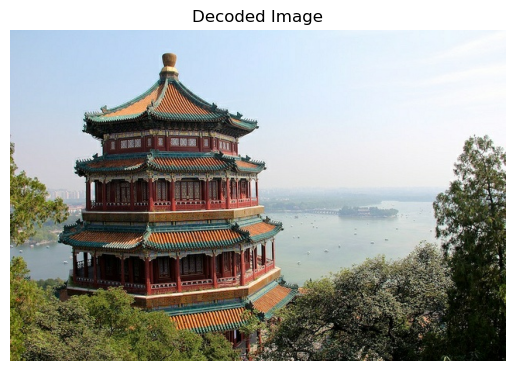

In [19]:
plt.imshow(decoded_img)
plt.title("Decoded Image")
plt.axis("off")
plt.show(block=False)
plt.pause(2)
plt.close()

In [20]:
from tensorflow.train import FeatureList, FeatureLists, SequenceExample

context = Features(feature={
    "author_id": Feature(int64_list=Int64List(value=[123])),
    "title": Feature(bytes_list=BytesList(value=[b"A", b"desert", b"place", b"."])),
    "pub_date": Feature(int64_list=Int64List(value=[1623, 12, 25]))
})

content = [["When", "shall", "we", "three", "meet", "again", "?"],
           ["In", "thunder", ",", "lightning", ",", "or", "in", "rain", "?"]]
comments = [["When", "the", "hurlyburly", "'s", "done", "."],
            ["When", "the", "battle", "'s", "lost", "and", "won", "."]]

def words_to_feature(words):
    return Feature(bytes_list=BytesList(value=[word.encode("utf-8")
                                               for word in words]))

content_features = [words_to_feature(sentence) for sentence in content]
comments_features = [words_to_feature(comment) for comment in comments]
            
sequence_example = SequenceExample(
    context=context,
    feature_lists=FeatureLists(feature_list={
        "content": FeatureList(feature=content_features),
        "comments": FeatureList(feature=comments_features)
    }))

print(type(sequence_example))

<class 'tensorflow.core.example.example_pb2.SequenceExample'>


In [21]:
serialized_sequence_example = sequence_example.SerializeToString()
context_feature_descriptions = {
    "author_id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "title": tf.io.VarLenFeature(tf.string),
    "pub_date": tf.io.FixedLenFeature([3], tf.int64, default_value=[0, 0, 0]),
}
sequence_feature_descriptions = {
    "content": tf.io.VarLenFeature(tf.string),
    "comments": tf.io.VarLenFeature(tf.string),
}
parsed_context, parsed_feature_lists = tf.io.parse_single_sequence_example(
    serialized_sequence_example, context_feature_descriptions, sequence_feature_descriptions)
parsed_content = tf.RaggedTensor.from_sparse(parsed_feature_lists["content"])
print(parsed_content)
print(parsed_feature_lists["content"].values)

<tf.RaggedTensor [[b'When', b'shall', b'we', b'three', b'meet', b'again', b'?'],
 [b'In', b'thunder', b',', b'lightning', b',', b'or', b'in', b'rain', b'?']]>
tf.Tensor(
[b'When' b'shall' b'we' b'three' b'meet' b'again' b'?' b'In' b'thunder'
 b',' b'lightning' b',' b'or' b'in' b'rain' b'?'], shape=(16,), dtype=string)


In [22]:
means = np.mean(X_train, axis=0, keepdims=True)
stds = np.std(X_train, axis=0, keepdims=True)
eps = keras.backend.epsilon()

model = keras.models.Sequential([
    keras.layers.Lambda(lambda inputs: (inputs - means) / (stds + eps)),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1),
])

class Standardization(keras.layers.Layer):
    def adapt(self, data_sample):
        self.means_ = np.mean(data_sample, axis=0, keepdims=True)
        self.stds_ = np.std(data_sample, axis=0, keepdims=True)
    def call(self, inputs):
        return (inputs - self.means_) / self.stds_ + keras.backend.epsilon()

std_layer = Standardization()
# std_layer.adapt(data_sample)
keras.layers.Normalization()

In [23]:
vocab = ["<1H OCEAN", "INLAND", "NEAR_OCCEAN", 'NEAR BAY', 'ICELAND']
indices = tf.range(len(vocab), dtype=tf.int64)
table_init = tf.lookup.KeyValueTensorInitializer(vocab, indices)
# 초기화 객체 생성
num_oov_buckets = 2 # oov(out-of-vocabulary) 갯수 지정
# 어휘 사전에 없는 값이 들어올 경우 oov에 할당
table = tf.lookup.StaticVocabularyTable(table_init, num_oov_buckets)

categories = tf.constant(["NEAR BAY", "DESERT", "INLAND", "INLAND"])
cat_indeices = table.lookup(categories)
print(cat_indeices)

cat_one_hot = tf.one_hot(cat_indeices, depth=len(vocab) + num_oov_buckets)
print(cat_one_hot)

tf.Tensor([3 5 1 1], shape=(4,), dtype=int64)
tf.Tensor(
[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]], shape=(4, 7), dtype=float32)


In [24]:
embedding_dim = 2
embed_init = tf.random.uniform([len(vocab) + num_oov_buckets, embedding_dim])
embedding_matrix = tf.Variable(embed_init)
print(embedding_matrix)

categories = tf.constant(["NEAR BAY", "DESERT", "INLAND", "INLAND"])
cat_indeices = table.lookup(categories)
print(cat_indeices)

cat_embed = tf.nn.embedding_lookup(embedding_matrix, cat_indeices)
print(cat_embed)

<tf.Variable 'Variable:0' shape=(7, 2) dtype=float32, numpy=
array([[0.25494385, 0.53029513],
       [0.7536186 , 0.17686665],
       [0.35639513, 0.52122307],
       [0.92888343, 0.945994  ],
       [0.15698087, 0.7481687 ],
       [0.9842775 , 0.4959575 ],
       [0.55323684, 0.6494658 ]], dtype=float32)>
tf.Tensor([3 5 1 1], shape=(4,), dtype=int64)
tf.Tensor(
[[0.92888343 0.945994  ]
 [0.9842775  0.4959575 ]
 [0.7536186  0.17686665]
 [0.7536186  0.17686665]], shape=(4, 2), dtype=float32)


In [25]:
regular_inputs = keras.layers.Input(shape=[8])
categories = keras.layers.Input(shape=[], dtype=tf.string)
cat_indeices = keras.layers.Lambda(lambda cats: table.lookup(cats), output_shape=(1,))(categories)
cat_embed = keras.layers.Embedding(input_dim=6, output_dim=2)(cat_indeices)
encoded_inputs = keras.layers.concatenate([regular_inputs, cat_embed])
outputs = keras.layers.Dense(1)(encoded_inputs)
model = keras.models.Model(inputs=[regular_inputs, categories], outputs=[outputs])

In [26]:
# 전처리층을 포함한 모델
norm_layer = tf.keras.layers.Normalization()
model = tf.keras.models.Sequential([
    norm_layer,
    tf.keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=2e-3))

norm_layer.adapt(X_train)  # 모든 특성의 평균과 분산을 계산합니다.
# 모델에서 정규화
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=5)

# 전처리를 별도로 하는 모델
norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(X_train)
# input 전처리
X_train_scaled = norm_layer(X_train)
X_valid_scaled = norm_layer(X_valid)
# 전처리층 없이 모델 구성
model = tf.keras.models.Sequential([tf.keras.layers.Dense(1)])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=2e-3))
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid));

Epoch 1/5
363/363 [==============================] - 1s 1ms/step - loss: 3.0567 - val_loss: 1.0524
Epoch 2/5
363/363 [==============================] - 0s 1ms/step - loss: 0.8035 - val_loss: 1.2078
Epoch 3/5
363/363 [==============================] - 0s 1ms/step - loss: 0.6575 - val_loss: 0.9169
Epoch 4/5
363/363 [==============================] - 0s 1ms/step - loss: 0.6245 - val_loss: 0.8511
Epoch 5/5
363/363 [==============================] - 0s 1ms/step - loss: 0.6070 - val_loss: 0.6123
Epoch 1/5
363/363 [==============================] - 1s 1ms/step - loss: 2.4999 - val_loss: 3.6810
Epoch 2/5
363/363 [==============================] - 0s 1ms/step - loss: 0.7645 - val_loss: 0.6125
Epoch 3/5
363/363 [==============================] - 0s 1ms/step - loss: 0.6371 - val_loss: 0.6193
Epoch 4/5
363/363 [==============================] - 0s 1ms/step - loss: 0.6121 - val_loss: 0.6196
Epoch 5/5
363/363 [==============================] - 0s 1ms/step - loss: 0.5929 - val_loss: 1.0021


In [27]:
age = tf.constant([[10.], [93.], [57.], [18.], [37.], [5.]])
discretize_layer = tf.keras.layers.Discretization(bin_boundaries=[18., 50.])
age_categories = discretize_layer(age)
print(age_categories)

discretize_layer = tf.keras.layers.Discretization(num_bins=3)
discretize_layer.adapt(age)
age_categories = discretize_layer(age)
print(age_categories)

tf.Tensor(
[[0]
 [2]
 [2]
 [1]
 [1]
 [0]], shape=(6, 1), dtype=int64)
tf.Tensor(
[[1]
 [2]
 [2]
 [1]
 [2]
 [0]], shape=(6, 1), dtype=int64)


In [28]:
hashing_layer = tf.keras.layers.Hashing(num_bins=2)
print(hashing_layer([["Paris"], ["Tokyo"], ["Auckland"], ["Montreal"]]))

tf.Tensor(
[[0]
 [1]
 [1]
 [1]], shape=(4, 1), dtype=int64)


In [29]:
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3)   # output_mode="multi_hot"(default)
print(onehot_layer(age_categories))

two_age_categories = np.array([[1, 0], [2, 2], [2, 0], [1,0]])
print(onehot_layer(two_age_categories))
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3, output_mode="count")
print(onehot_layer(two_age_categories))

onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3, output_mode="one_hot")
print([onehot_layer(cat) for cat in tf.transpose(two_age_categories)])

tf.Tensor(
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]], shape=(6, 3), dtype=float32)
tf.Tensor(
[[1. 1. 0.]
 [0. 0. 1.]
 [1. 0. 1.]
 [1. 1. 0.]], shape=(4, 3), dtype=float32)
tf.Tensor(
[[1. 1. 0.]
 [0. 0. 2.]
 [1. 0. 1.]
 [1. 1. 0.]], shape=(4, 3), dtype=float32)
[<tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)>, <tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)>]


In [30]:
cities = ["Auckland", "Paris", "Paris", "San Francisco"]
str_lookup_layer = tf.keras.layers.StringLookup()
str_lookup_layer.adapt(cities)
print(str_lookup_layer([["Paris"], ["Auckland"], ["Auckland"], ["Montreal"]]))

str_lookup_layer = tf.keras.layers.StringLookup(num_oov_indices=5)
str_lookup_layer.adapt(cities)
print(str_lookup_layer([["Paris"], ["Auckland"], ["Foo"], ["Bar"], ["Baz"]]))

str_lookup_layer = tf.keras.layers.StringLookup(output_mode="one_hot")
str_lookup_layer.adapt(cities)
print(str_lookup_layer([["Paris"], ["Auckland"], ["Auckland"], ["Montreal"]]))

# 추가 코드 - IntegerLookup 층을 사용한 예제
ids = [123, 456, 789]
int_lookup_layer = tf.keras.layers.IntegerLookup()
int_lookup_layer.adapt(ids)
print(int_lookup_layer([[123], [456], [123], [111]]))

tf.Tensor(
[[1]
 [3]
 [3]
 [0]], shape=(4, 1), dtype=int64)
tf.Tensor(
[[5]
 [7]
 [4]
 [3]
 [4]], shape=(5, 1), dtype=int64)
tf.Tensor(
[[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]], shape=(4, 4), dtype=float32)
tf.Tensor(
[[3]
 [2]
 [3]
 [0]], shape=(4, 1), dtype=int64)


In [31]:
import tensorflow_transform as tft

def preprocess(inputs):  # inputs is a batch of input features
    median_age = inputs["housing_median_age"]
    ocean_proximity = inputs["ocean_proximity"]
    standardized_age = tft.scale_to_z_score(median_age - tft.mean(median_age))
    ocean_proximity_id = tft.compute_and_apply_vocabulary(ocean_proximity)
    return {
        "standardized_median_age": standardized_age,
        "ocean_proximity_id": ocean_proximity_id
    }

In [32]:
import tensorflow_datasets as tfds

datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]

In [33]:
print(tfds.list_builders())

['abstract_reasoning', 'accentdb', 'aeslc', 'aflw2k3d', 'ag_news_subset', 'ai2_arc', 'ai2_arc_with_ir', 'aloha_mobile', 'amazon_us_reviews', 'anli', 'answer_equivalence', 'arc', 'asqa', 'asset', 'assin2', 'asu_table_top_converted_externally_to_rlds', 'austin_buds_dataset_converted_externally_to_rlds', 'austin_sailor_dataset_converted_externally_to_rlds', 'austin_sirius_dataset_converted_externally_to_rlds', 'bair_robot_pushing_small', 'bc_z', 'bccd', 'beans', 'bee_dataset', 'beir', 'berkeley_autolab_ur5', 'berkeley_cable_routing', 'berkeley_fanuc_manipulation', 'berkeley_gnm_cory_hall', 'berkeley_gnm_recon', 'berkeley_gnm_sac_son', 'berkeley_mvp_converted_externally_to_rlds', 'berkeley_rpt_converted_externally_to_rlds', 'big_patent', 'bigearthnet', 'billsum', 'binarized_mnist', 'binary_alpha_digits', 'ble_wind_field', 'blimp', 'booksum', 'bool_q', 'bot_adversarial_dialogue', 'bridge', 'bridge_data_msr', 'bucc', 'c4', 'c4_wsrs', 'caltech101', 'caltech_birds2010', 'caltech_birds2011', 'c

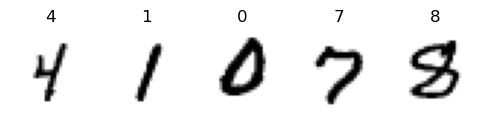

In [34]:
plt.figure(figsize=(6,3))
mnist_train = mnist_train.repeat(5).batch(32).prefetch(1)
for item in mnist_train:
    images = item["image"]
    labels = item["label"]
    for index in range(5):
        plt.subplot(1, 5, index + 1)
        image = images[index, ..., 0]
        label = labels[index].numpy()
        plt.imshow(image, cmap="binary")
        plt.title(label)
        plt.axis("off")
    break # just showing part of the first batch

In [35]:
datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]
mnist_train = mnist_train.repeat(5).batch(32)
mnist_train = mnist_train.map(lambda items: (items["image"], items["label"]))
mnist_train = mnist_train.prefetch(1)
for images, labels in mnist_train.take(1):
    print(images.shape)
    print(labels.numpy())

(32, 28, 28, 1)
[4 1 0 7 8 1 2 7 1 6 6 4 7 7 3 3 7 9 9 1 0 6 6 9 9 4 8 9 4 7 3 3]


In [36]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [37]:
datasets = tfds.load(name="mnist", batch_size=32, as_supervised=True)
mnist_train = datasets["train"].repeat().prefetch(1)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28, 1]),
    keras.layers.Lambda(lambda images: tf.cast(images, tf.float32)),
    keras.layers.Dense(10, activation="softmax")])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])
model.fit(mnist_train, steps_per_epoch=60000 // 32, epochs=5);

Epoch 1/5
1875/1875 [==============================] - 2s 1ms/step - loss: 31.7173 - accuracy: 0.8418
Epoch 2/5
1875/1875 [==============================] - 2s 967us/step - loss: 26.0144 - accuracy: 0.8686
Epoch 3/5
1875/1875 [==============================] - 2s 888us/step - loss: 25.3683 - accuracy: 0.8731
Epoch 4/5
1875/1875 [==============================] - 2s 991us/step - loss: 24.7133 - accuracy: 0.8756
Epoch 5/5
1875/1875 [==============================] - 2s 962us/step - loss: 23.8410 - accuracy: 0.8783


In [38]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_set = train_set.shuffle(len(X_train))
valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
valid_set = valid_set.shuffle(len(X_valid))
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))
# test_set = test_set.shuffle(len(X_test))

In [39]:
for X, y in train_set:
    print(type(X), X.shape)
    print(y)
    break

<class 'tensorflow.python.framework.ops.EagerTensor'> (28, 28)
tf.Tensor(2, shape=(), dtype=uint8)


In [40]:
def create_example(image, label):
    image_data = tf.io.serialize_tensor(image)
    #image_data = tf.io.encode_jpeg(image[..., np.newaxis])
    return Example(
        features=Features(
            feature={
                "image": Feature(bytes_list=BytesList(value=[image_data.numpy()])), # int array를 byte로 받음
                "label": Feature(int64_list=Int64List(value=[label])),
            }))

for image, label in valid_set.take(1):
    print(create_example(image, label))

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\010\004\022\010\022\002\010\034\022\002\010\034\"\220\006\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\00

In [41]:
import os
from contextlib import ExitStack
# 여러 컨텍스트 관리자(예: `with` 문에서 사용하는 객체)를 동적으로 관리하거나, 
# 필요에 따라 컨텍스트 관리자를 나중에 추가하고 제거할 수 있게 해주는 클래스

os.makedirs('./my_mnist', exist_ok=True)
def write_tfrecords(name, dataset, n_shards=10):
    paths = ["my_mnist/{}.tfrecord-{:05d}-of-{:05d}".format(name, index, n_shards)
             for index in range(n_shards)]
    # 저장할 파일명 지정
    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(path))
                   for path in paths]
        # 각 파일의 writer 생성
        for index, (image, label) in dataset.enumerate():
            shard = index % n_shards
            example = create_example(image, label)
            writers[shard].write(example.SerializeToString())
            # 객체를 string으로 저장
    return paths

In [42]:
train_filepaths = write_tfrecords("my_fashion_mnist.train", train_set)
valid_filepaths = write_tfrecords("my_fashion_mnist.valid", valid_set)
test_filepaths = write_tfrecords("my_fashion_mnist.test", test_set)

In [43]:
def preprocess(tfrecord):
    feature_descriptions = {
        "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "label": tf.io.FixedLenFeature([], tf.int64, default_value=-1)
    }
    example = tf.io.parse_single_example(tfrecord, feature_descriptions)
    image = tf.io.parse_tensor(example["image"], out_type=tf.uint8)
    image = tf.reshape(image, shape=[28, 28])
    
    return image, example["label"]

def mnist_dataset(filepaths, n_read_threads=5, shuffle_buffer_size=None,
                  n_parse_threads=5, batch_size=32, cache=True):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    
    return dataset.prefetch(1)

In [44]:
train_set = mnist_dataset(train_filepaths, shuffle_buffer_size=60000)
valid_set = mnist_dataset(valid_filepaths)
test_set = mnist_dataset(test_filepaths)

(32, 28, 28)


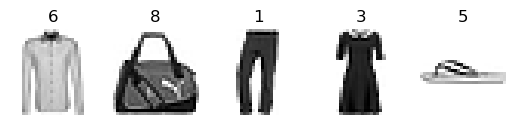

In [45]:
for X, y in train_set.take(1):
    print(X.shape)
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X[i].numpy(), cmap="binary")
        plt.axis("off")
        plt.title(str(y[i].numpy()))

In [46]:
standardization = keras.layers.Normalization(input_shape=[28, 28])

sample_image_batches = train_set.take(100).map(lambda image, label: image)
sample_images = np.concatenate(list(sample_image_batches.as_numpy_iterator()),
                               axis=0).astype(np.float32)
standardization.adapt(sample_images)

model = keras.models.Sequential([
    standardization,
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam", metrics=["accuracy"])

In [47]:
from datetime import datetime

logs = os.path.join("my_logs", "run_" + datetime.now().strftime("%Y%m%d_%H%M%S"))

tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=logs, histogram_freq=1, profile_batch=10)

model.fit(train_set, epochs=5, validation_data=valid_set,
          callbacks=[tensorboard_cb]);

Epoch 1/5
1719/1719 [==============================] - 5s 2ms/step - loss: 0.4466 - accuracy: 0.8411 - val_loss: 0.3693 - val_accuracy: 0.8652
Epoch 2/5
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3362 - accuracy: 0.8758 - val_loss: 0.3363 - val_accuracy: 0.8784
Epoch 3/5
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2981 - accuracy: 0.8900 - val_loss: 0.3217 - val_accuracy: 0.8854
Epoch 4/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2742 - accuracy: 0.8983 - val_loss: 0.3323 - val_accuracy: 0.8828
Epoch 5/5
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2559 - accuracy: 0.9049 - val_loss: 0.3353 - val_accuracy: 0.8852


In [48]:
from pathlib import Path

root = "https://ai.stanford.edu/~amaas/data/sentiment/"
filename = "aclImdb_v1.tar.gz"
filepath = tf.keras.utils.get_file(filename, root + filename, extract=True,
                                   cache_dir=".")
path = Path(filepath).with_name("aclImdb")
path

WindowsPath('datasets/aclImdb')

In [49]:
def review_paths(dirpath):
    return [str(path) for path in dirpath.glob("*.txt")]

train_pos = review_paths(path / "train" / "pos")
train_neg = review_paths(path / "train" / "neg")
test_valid_pos = review_paths(path / "test" / "pos")
test_valid_neg = review_paths(path / "test" / "neg")

len(train_pos), len(train_neg), len(test_valid_pos), len(test_valid_neg)

(12500, 12500, 12500, 12500)

In [50]:
np.random.shuffle(test_valid_pos)
np.random.shuffle(test_valid_neg)

test_pos = test_valid_pos[:5000]
test_neg = test_valid_neg[:5000]
valid_pos = test_valid_pos[5000:]
valid_neg = test_valid_neg[5000:]

In [51]:
def imdb_dataset(filepaths_positive, filepaths_negative):
    reviews = []
    labels = []
    for filepaths, label in ((filepaths_negative, 0), (filepaths_positive, 1)):
        for filepath in filepaths:
            with open(filepath) as review_file:
                reviews.append(review_file.read())
            labels.append(label)
    return tf.data.Dataset.from_tensor_slices(
        (tf.constant(reviews), tf.constant(labels)))

In [52]:
batch_size = 32

train_set = imdb_dataset(train_pos, train_neg).shuffle(25000, seed=42)
train_set = train_set.batch(batch_size).prefetch(1)
valid_set = imdb_dataset(valid_pos, valid_neg).batch(batch_size).prefetch(1)
test_set = imdb_dataset(test_pos, test_neg).batch(batch_size).prefetch(1)

In [53]:
max_tokens = 1000
sample_reviews = train_set.map(lambda review, label: review)
text_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens, output_mode="tf_idf")
text_vectorization.adapt(sample_reviews)

text_vectorization.get_vocabulary()[:10]

['[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i']

In [54]:
model = tf.keras.Sequential([
    text_vectorization,
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
782/782 [==============================] - 6s 7ms/step - loss: 0.4494 - accuracy: 0.8197 - val_loss: 0.3672 - val_accuracy: 0.8510
Epoch 2/5
782/782 [==============================] - 5s 7ms/step - loss: 0.3698 - accuracy: 0.8519 - val_loss: 0.3727 - val_accuracy: 0.8511
Epoch 3/5
782/782 [==============================] - 5s 6ms/step - loss: 0.3264 - accuracy: 0.8678 - val_loss: 0.3495 - val_accuracy: 0.8561
Epoch 4/5
782/782 [==============================] - 4s 5ms/step - loss: 0.2726 - accuracy: 0.8888 - val_loss: 0.3561 - val_accuracy: 0.8522
Epoch 5/5
782/782 [==============================] - 4s 5ms/step - loss: 0.2148 - accuracy: 0.9154 - val_loss: 0.4259 - val_accuracy: 0.8346


In [55]:
def compute_mean_embedding(inputs):
    not_pad = tf.math.count_nonzero(inputs, axis=-1)
    n_words = tf.math.count_nonzero(not_pad, axis=-1, keepdims=True)
    sqrt_n_words = tf.math.sqrt(tf.cast(n_words, tf.float32))
    return tf.reduce_sum(inputs, axis=1) / sqrt_n_words

another_example = tf.constant([[[1., 2., 3.], [4., 5., 0.], [0., 0., 0.]],
                               [[6., 0., 0.], [0., 0., 0.], [0., 0., 0.]]])
compute_mean_embedding(another_example)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[3.535534 , 4.9497476, 2.1213205],
       [6.       , 0.       , 0.       ]], dtype=float32)>

In [56]:
embedding_size = 20

text_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens, output_mode="int")
text_vectorization.adapt(sample_reviews)

model = tf.keras.Sequential([
    text_vectorization,
    tf.keras.layers.Embedding(input_dim=max_tokens,
                              output_dim=embedding_size,
                              mask_zero=True),  # <pad> tokens => zero vectors
    tf.keras.layers.Lambda(compute_mean_embedding),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit(train_set, epochs=5, validation_data=valid_set);

Epoch 1/5
782/782 [==============================] - 7s 8ms/step - loss: 0.4579 - accuracy: 0.7794 - val_loss: 0.4056 - val_accuracy: 0.8089
Epoch 2/5
782/782 [==============================] - 6s 8ms/step - loss: 0.3308 - accuracy: 0.8604 - val_loss: 0.3199 - val_accuracy: 0.8617
Epoch 3/5
782/782 [==============================] - 6s 8ms/step - loss: 0.3166 - accuracy: 0.8646 - val_loss: 0.3163 - val_accuracy: 0.8644
Epoch 4/5
782/782 [==============================] - 6s 8ms/step - loss: 0.3108 - accuracy: 0.8686 - val_loss: 0.3334 - val_accuracy: 0.8548
Epoch 5/5
782/782 [==============================] - 6s 8ms/step - loss: 0.3061 - accuracy: 0.8693 - val_loss: 0.3198 - val_accuracy: 0.8633


In [57]:
import tensorflow_datasets as tfds

datasets = tfds.load(name="imdb_reviews")
train_set, test_set = datasets["train"], datasets["test"]

for example in train_set.take(1):
    print(example["text"])
    print(example["label"])

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
